# Import

In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import random
from os.path import isdir, join
import regex as re
import gc
import sklearn
import pickle

import librosa
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd 

from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, Conv1D
from sklearn.model_selection import train_test_split
import keras

import warnings
warnings.filterwarnings("ignore")

# Load File

### Check file

In [2]:
# os.chdir('/media/tawheed/3E966F77EAAB612F/thesis/audioClassification')
dir_path = os.getcwd()
print(dir_path )
play_audio_dir_path= os.path.join(dir_path , 'train/audio/bird')
play_audio_dir= os.chdir(play_audio_dir_path)
print(os.getcwd())


/media/tawheed/3E966F77EAAB612F/thesis/audioClassification
/media/tawheed/3E966F77EAAB612F/thesis/audioClassification/train/audio/bird


In [3]:
ipd.Audio(os.listdir()[2])
# os.listdir()

In [4]:
os.chdir('/media/tawheed/3E966F77EAAB612F/thesis/audioClassification')
print(os.getcwd())

/media/tawheed/3E966F77EAAB612F/thesis/audioClassification


## Check Training Audio Folder

In [5]:
train_audio_path = 'train/audio/'
print(len(os.listdir(train_audio_path)))
print(os.listdir(train_audio_path))

31
['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', '_background_noise_']


# Exploratory Data Analysis

The following Features are Visualised:

1. Raw Audio
2. MFCCs
3. First and Second Order Deltas of MFCCs


#### These features will be considered for the feature set

## Loading a sample file to study

In [6]:
# At 8000 
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples2, sample_rate2 = librosa.load(str(train_audio_path) + filename, 8000)
# At 16000 
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path) + filename, 16000)
print('Sample Rate: ', sample_rate)
print()
ipd.Audio(samples, rate=sample_rate)

Sample Rate:  16000



## Plotting Raw Data

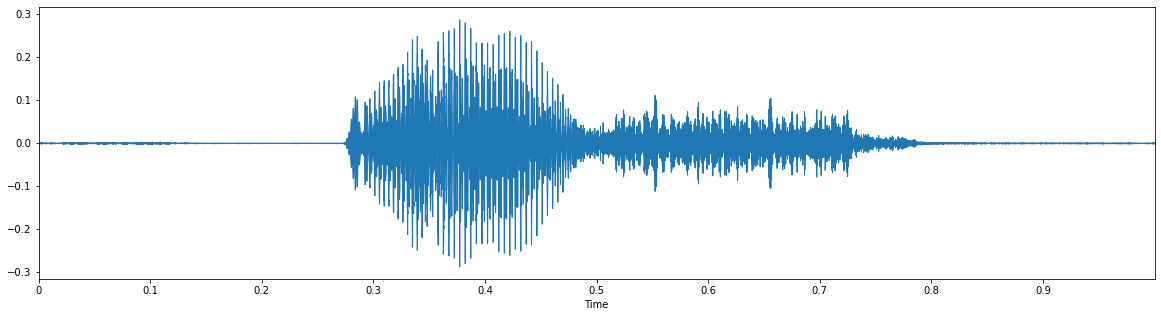

In [7]:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(samples, sr=16000)

# MFCCs (First 13)

#### This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. 
#### The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.

(13, 32)


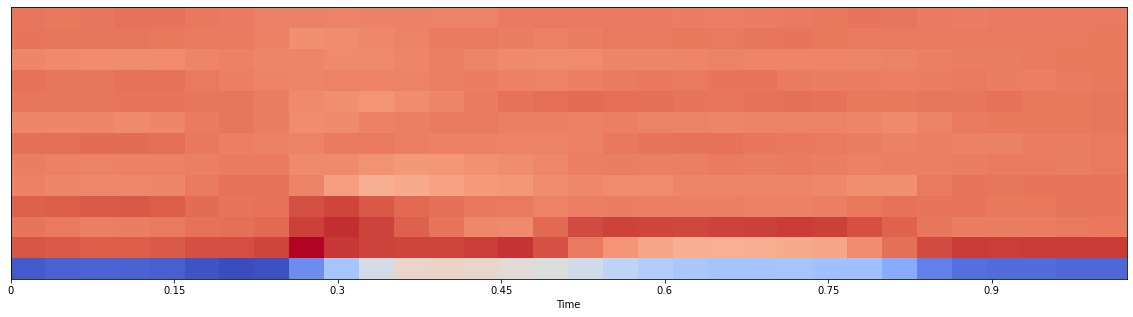

In [8]:
plt.figure(figsize=(20,5))
mfcc = librosa.feature.mfcc(samples, sr=16000, n_mfcc=13)
print(mfcc.shape)

librosa.display.specshow(mfcc, sr=16000, x_axis='time')

### First and Second Order Deltas of MFCCs (First 13)

#### Deltas are just the nth order derivative of the MFCCs. The provide a simpler overview of the sample.

(13, 32)


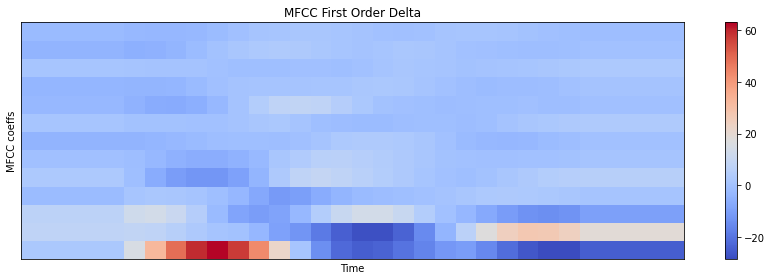

In [9]:
delta1_mfcc = librosa.feature.delta(mfcc, order=1)
print(delta1_mfcc.shape)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta1_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC First Order Delta')
plt.colorbar()
plt.tight_layout()

(13, 32)


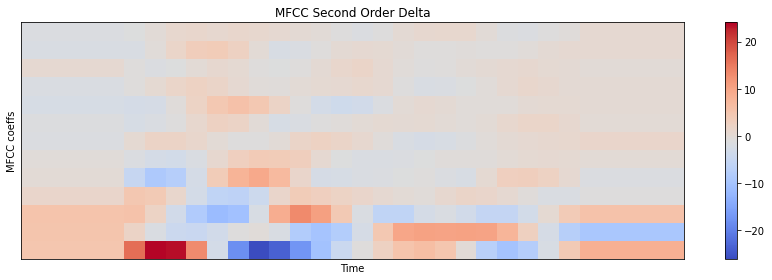

In [10]:
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC Second Order Delta')
plt.colorbar()
plt.tight_layout()

### Example of final stacked feature set

In [11]:
features = np.concatenate((mfcc, delta1_mfcc, delta2_mfcc), axis=0)

print(features.shape)

(39, 32)


# Data Loading, Preprocessing and Feature Extraction

<b>Details:</b>
1. All files are sampled at 16000 HZ
2. The file length has been kept constant at 1 second.
3. Zero Padding has been used in sound processing to make audio files of same length. The same has been implemented here.
4. For extremely long audio files, they have been split into smaller 1 second samples.

<b>Features</b>
1. MFCCs and its first and second order deltas are loaded.
2. These are stacked to create the feature set.

### <b>Variables to load data.<b/>
### sr - Sample Rate
### Legal Labels - Categories to Classify

In [12]:
sr = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

# Paths
train_data_path = 'train/audio'
test_data_path = 'test'

# Path Helper
ext = 'wav'

### Utility Function
Task - Collect all file names.

In [13]:
def collect_files(path):
    
    # Simple Regex to collect paths
    fpaths = glob(os.path.join(path, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    
    labels = []
    for fpath in fpaths:
        fpath = fpath.replace('\\', '/')
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        fpath = fpath.replace('\\', '/')
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

In [14]:
'''
Get paths and labels.
'''

labels, filenames = collect_files(train_data_path)


In [15]:
'''
Padding -> Pad smaller samples with 0

Reduce -> Reduce audio to predefined size.

Labellize -> Tranform label to suitable format for model.
'''

def padding(samples):
    if len(samples) >= sr: 
        return samples
    else: 
        return np.pad(samples, pad_width=(sr - len(samples), 0), mode='constant', constant_values=(0, 0))

def reduce(samples, sr=16000, num=20):
    for i in range(num):
        cut = np.random.randint(0, len(samples) - sr)
        yield samples[cut: cut + sr]

def labellize(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

## Load MFCCs

In [16]:
Y_tr = []
X_tr = []

for label, fname in tqdm(zip(labels, filenames)):
    
    samples, sample_rate = librosa.load(os.path.join(train_data_path, label, fname), sr = 16000)
    samples = padding(samples)
    if len(samples) > 16000:
        n_samples = reduce(samples)
    else: 
        n_samples = [samples]
    for samples in n_samples:
        
        # Feature Extraction
        mfcc = librosa.feature.mfcc(samples, sr = 16000, n_mfcc = 13)
        delta1 = librosa.feature.delta(mfcc, order=1)
        delta2 = librosa.feature.delta(mfcc, order=2)
        
        features = np.concatenate((mfcc, delta1, delta2), axis=0)
        
        Y_tr.append(label)
        X_tr.append(features)

64727it [07:25, 145.45it/s]


In [17]:
pd.DataFrame(features)

0           1           2           3           4           5   \
0   98.771820  109.751404  110.801636  107.688293  107.392273  108.550468   
1  -10.808228   -3.034975   -2.625295   -6.062491   -6.813281   -6.429516   
2    6.819105    4.313939    1.198337   -2.445665   -1.909901   -0.891959   
3    2.866107    2.336526    3.467356    2.197690    2.247614    2.366238   
4   -4.899947   -0.536424    1.421896    4.448718    4.155728   -0.414552   
5   -3.164075   -2.537708   -0.768723    2.698230    2.881855    2.181678   
6   -2.521226    4.181240    1.432038   -0.898536   -0.782192   -3.976036   
7   -8.408844   -2.232646   -0.853469   -4.108702   -7.509082   -6.493001   
8   -0.519844   -0.616776    2.967798   -0.872492   -3.444278   -1.968653   
9    4.356352    3.443735    1.460974    0.811261    0.671406    0.478027   
10   1.987420    2.514933    0.504524   -0.121608    1.563070    0.638396   
11   2.718467    0.602354    0.908360    1.198769    2.517280    1.305807   
12   2.582415    2.231163    5.022196    3.928064    1.836317    2.517075   
13   0.827097    0.827097    0.827097    0.827097    0.827097    0.054398   
14   0.008584    0.008584    0.008584    0.008584    0.008584   -0.556581   
15  -0.952608   -0.952608   -0.952608   -0.952608   -0.952608   -0.679027   
16  -0.202047   -0.202047   -0.202047   -0.202047   -0.202047   -0.119775   
17   0.170979    0.170979    0.170979    0.170979    0.170979   -0.267298   
18   0.287910    0.287910    0.287910    0.287910    0.287910   -0.135177   
19  -0.315407   -0.315407   -0.315407   -0.315407   -0.315407   -0.711392   
20   0.184826    0.184826    0.184826    0.184826    0.184826   -0.087579   
21  -0.502708   -0.502708   -0.502708   -0.502708   -0.502708   -0.441518   
22  -1.408567   -1.408567   -1.408567   -1.408567   -1.408567   -1.269261   
23  -0.236325   -0.236325   -0.236325   -0.236325   -0.236325   -0.139591   
24  -0.232848   -0.232848   -0.232848   -0.232848   -0.232848   -0.061806   
25  -0.280932   -0.280932   -0.280932   -0.280932   -0.280932   -0.287146   
26  -0.414564   -0.414564   -0.414564   -0.414564   -0.414564    0.090533   
27  -0.260214   -0.260214   -0.260214   -0.260214   -0.260214    0.139256   
28   0.451304    0.451304    0.451304    0.451304    0.451304    0.174096   
29   0.004789    0.004789    0.004789    0.004789    0.004789    0.097371   
30  -0.558613   -0.558613   -0.558613   -0.558613   -0.558613   -0.099606   
31  -0.627726   -0.627726   -0.627726   -0.627726   -0.627726   -0.603686   
32  -0.047688   -0.047688   -0.047688   -0.047688   -0.047688    0.212743   
33  -0.004147   -0.004147   -0.004147   -0.004147   -0.004147    0.397301   
34  -0.021047   -0.021047   -0.021047   -0.021047   -0.021047    0.239213   
35  -0.276821   -0.276821   -0.276821   -0.276821   -0.276821   -0.009661   
36   0.274885    0.274885    0.274885    0.274885    0.274885    0.281013   
37  -0.044837   -0.044837   -0.044837   -0.044837   -0.044837   -0.032597   
38  -0.336501   -0.336501   -0.336501   -0.336501   -0.336501   -0.109162   

            6           7           8           9   ...          22  \
0   110.518295  110.474144  110.562340  108.572418  ...  107.319397   
1    -6.512070   -6.264503   -6.222177   -8.660334  ...   -2.575262   
2    -0.159831   -0.797822   -3.345535   -3.724996  ...    3.607901   
3    -0.555004    3.439132    0.977488    2.487230  ...    2.061670   
4    -4.379553    1.978768   -0.105112   -0.031850  ...   -0.074919   
5     0.973638   -0.023189   -1.473364   -2.199115  ...    3.377723   
6    -0.758167    0.769485   -2.829044   -4.133841  ...    0.879456   
7    -2.731445   -3.699637   -3.001147   -3.334509  ...   -4.654920   
8    -2.103762   -4.203363   -2.560707   -1.762859  ...   -2.281569   
9    -2.055594   -7.310775   -6.864674   -4.608169  ...    1.673166   
10   -3.051712   -1.410134    2.974461    0.366570  ...    0.842674   
11    0.388853   -0.339887    0.165429    1.533903  ...   -2.567241   
12    3

In [26]:
df = pd.DataFrame(columns=['features', 'label'])
df['features'] = X_tr
df['label'] = Y_tr

In [27]:
# print(fname)
df.to_csv('audioClasification.csv', index=False)

In [28]:
df.head(5)

features label
0  [[-562.60834, -562.18823, -560.3022, -558.3536...   bed
1  [[-497.07922, -490.02542, -482.79483, -488.187...   bed
2  [[-857.4219, -653.7514, -505.745, -473.04022, ...   bed
3  [[-603.1954, -602.3672, -602.42694, -594.35474...   bed
4  [[-602.7496, -600.9761, -602.8721, -601.9168, ...   bed